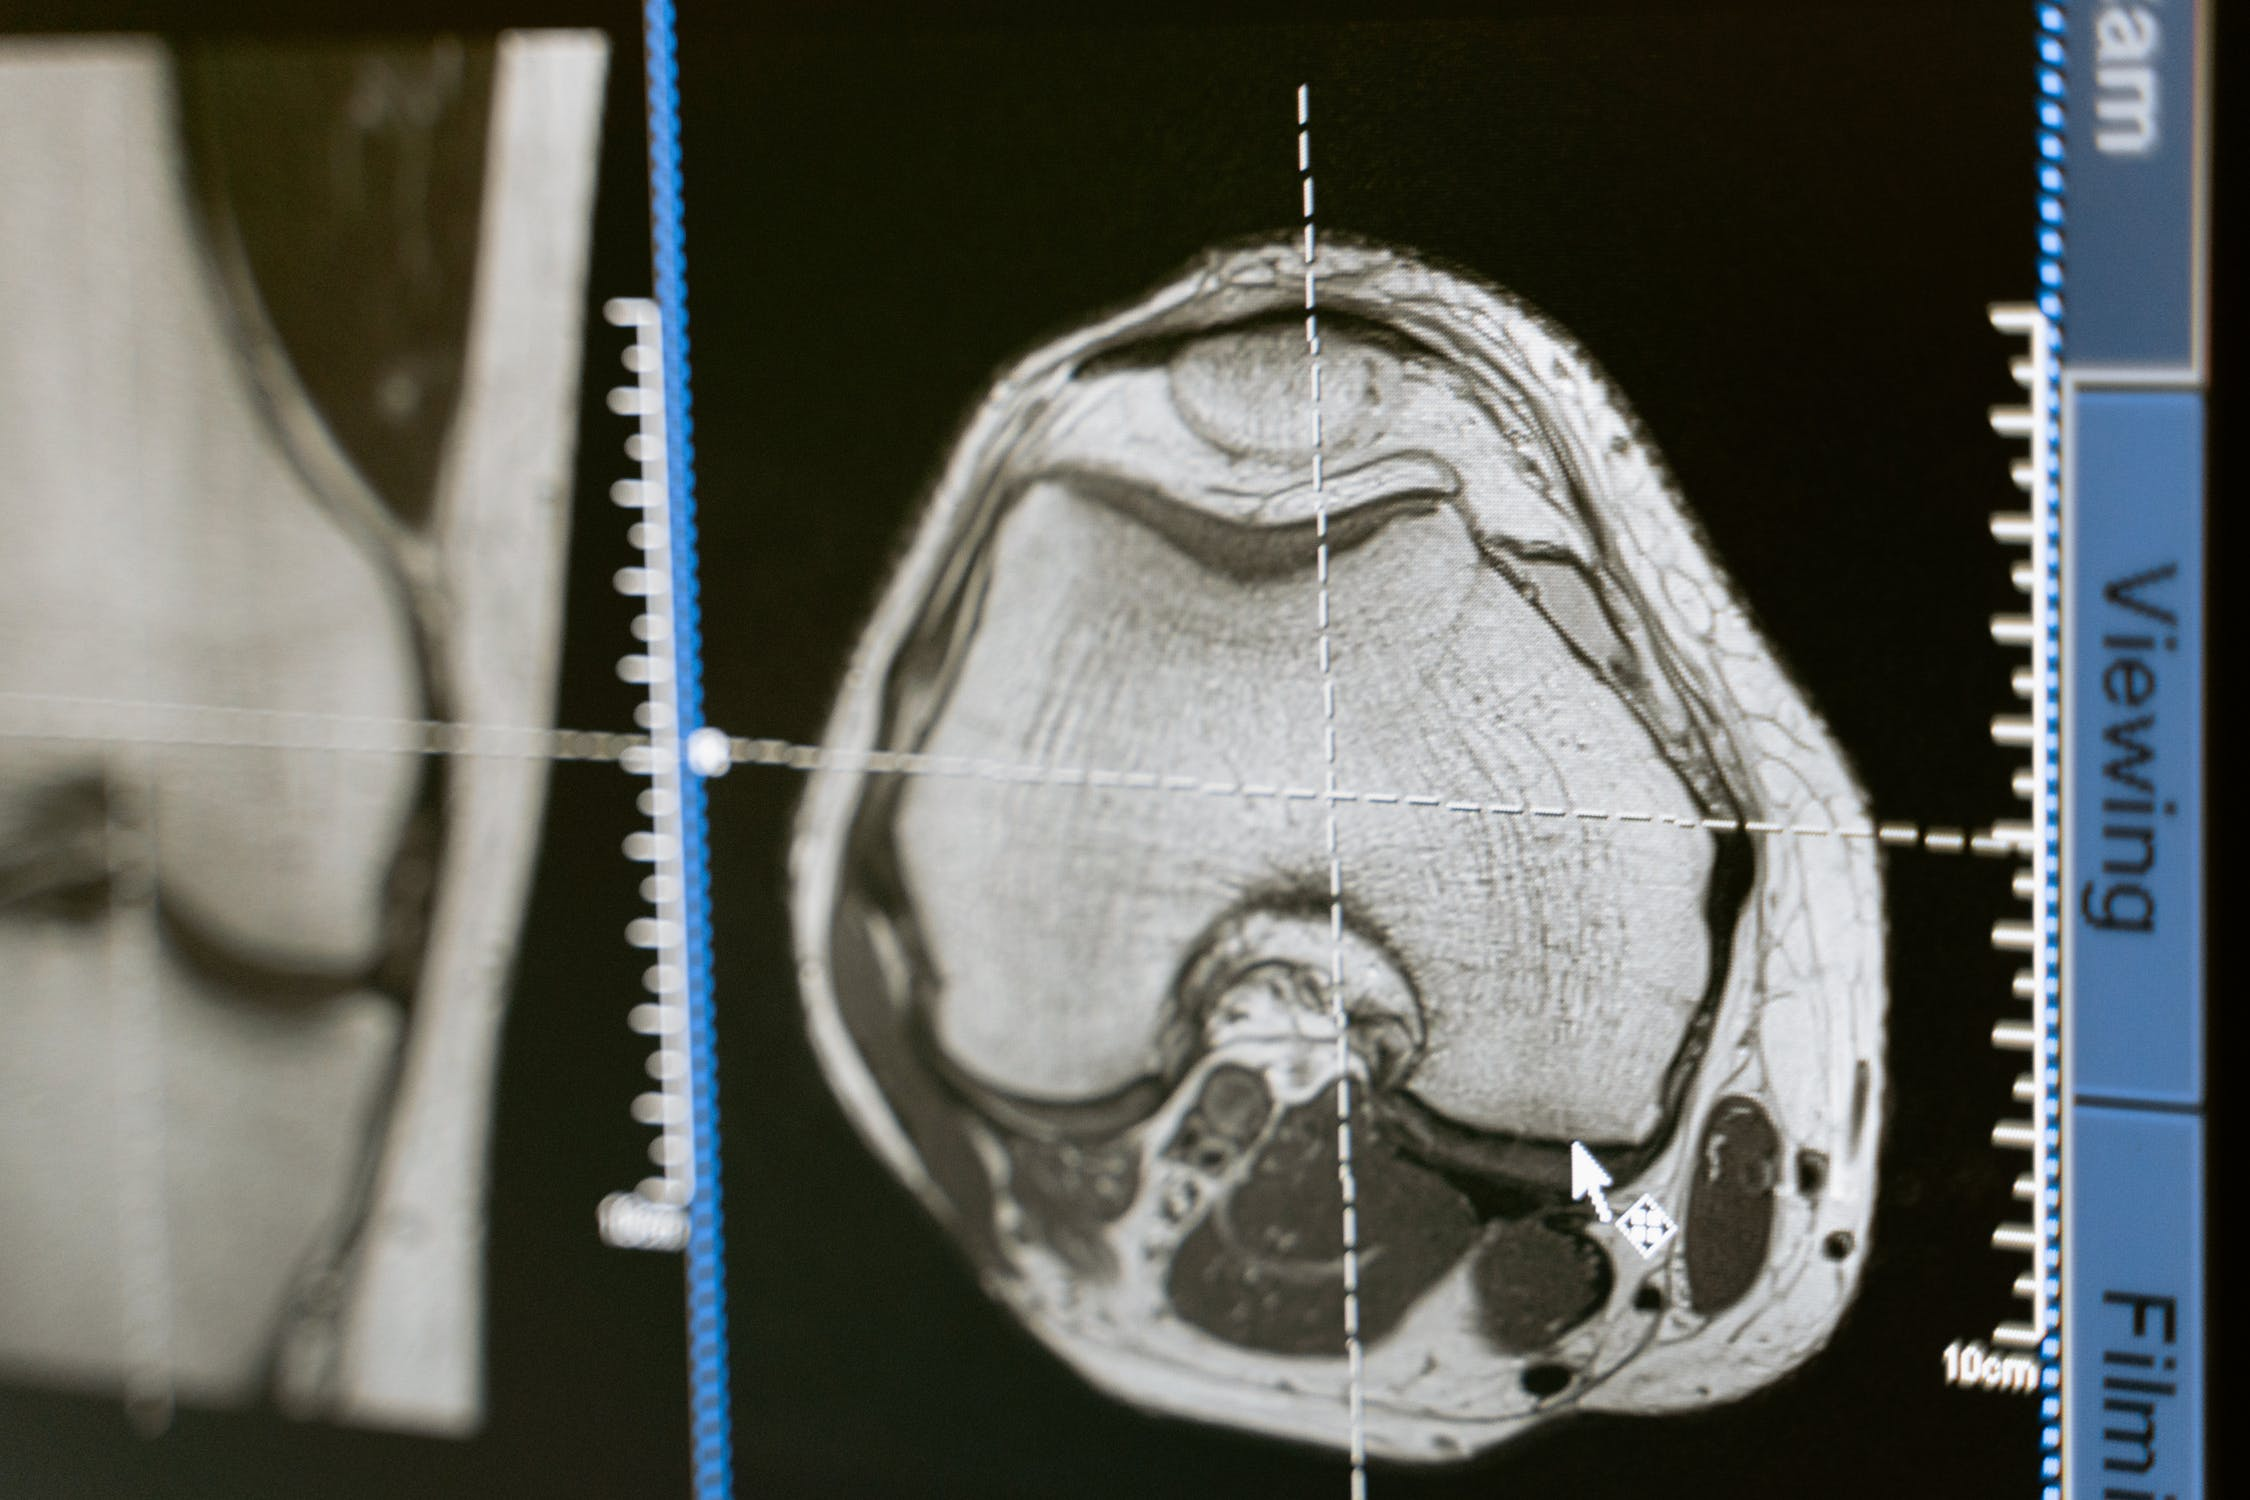

# **Segmentation of images obtained via Magnetic Resonance Imaging for the purpose of detecting presence of brain tumor**

In [ ]:
Importing necessary dependancies

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model ,Sequential
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D,MaxPooling2D, concatenate, Dense, Flatten, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


* * * Loading data 

In [3]:
#Loading the black and white mask images
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
#Loading the brain images
image_files = [file.replace('_mask', '') for file in mask_files]

**Assembling MRI scans with the corresponding masks**

First of all, there can be two category of images,one with tumor detected via the mask and the other with no tumor detected.
For MRI scans with a tumor detected, we are labeling them with 1,otherwise 0.



In [4]:
#Defining the function for labeling the masks
def mask_labelizer(mask_image):
    mask_image=cv2.imread(mask_image)
    label=np.max(mask_image)
    if(label>0):
        label=1
    else:
        label=0
    return label


In [5]:
#Assembling the MRI scans with their corresponding masks into a dataframe
MRI_DATA = pd.DataFrame(
    {              "images": image_files,
                   "masks": mask_files,
                   "label":[
                       mask_labelizer(mask) for mask in mask_files #Using List Apprehension
                   ]}
)
#Displaying the dataframe
MRI_DATA.head()

,images,masks,label
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1


In [6]:
#Verifying that correct labeling has taken place
MRI_DATA['label'].unique()

array([0, 1])

In [ ]:
#Number of images
MRI_DATA.shape

**Looking at the MRI Scans with corresponding masks**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[40,40])
for i in range(32):
   
    if(i%2==0):
        plt.subplot(8,4,i+1)        
        plt.title('MRI_Scan')
        plt.imshow(np.array(cv2.imread(MRI_DATA['images'].iloc[i])))
        
    else:
        plt.subplot(8,4,i+1)
        label=mask_labelizer(MRI_DATA['masks'].iloc[i])
        if(label==0):
                label='No Tumor'
        else:
                label='Tumor'
        plt.title(label)
        plt.imshow(np.array(cv2.imread(MRI_DATA['masks'].iloc[i])))
       


    


**Splitting data into training and testing**

In [ ]:
from sklearn.model_selection import train_test_split
MRI_train,MRI_test=train_test_split(MRI_DATA,test_size=0.1,random_state=0)
MRI_test,MRI_val=train_test_split(MRI_test,test_size=0.5,random_state=0)
print('Shape of training data : {}\nShape of test data: {}\nShape of Validation data: {} '.format(len(MRI_train),len(MRI_test),len(MRI_val)))

**Data Generator for Image Augmentation **
This is an important step to prevent overfitting and providing our model exposure to a variety of images

In [ ]:
'''Function for preprocessing images'''
#---------------------------------------------------------------------------------------------------------------------------------------------------------#
def preprocess_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    #Converting Masks into black and white images
    mask[mask>0.5]=1
    mask[mask<=0.5]=0
    return (img, mask)
#---------------------------------------------------------------------------------------------------------------------------------------------------------#
'''Function for data augmentation'''
def image_augmentor(
       data_frame, batch_size,
        aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)#Data Generator for Images
    mask_datagen = ImageDataGenerator(**aug_dict) #Data Generator for Masks
    
   #----------------------------------------image augmentation for MRI scans-------------------------------------------------------------------------------
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "images",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
   #-----------------------------------------------------image augmentation for masks-----------------------------------------------------------------------

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "masks",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
  #--------------------------------------------------------------------------------------------------------------------------------------------------------
    train_augmentor = zip(image_generator, mask_generator)
    
    for (image, mask) in train_augmentor:
        image, mask = preprocess_data(image, mask)
        yield (image,mask)



# **Model Architecture**

For image segmentation tasks,widely used models are of "U-net" architecture. These models have an encoder unit(contracting unit) followed by a decoder unit(expansive unit). The two units are connected by a bridge layer.Image is downscaled in the contracting layer and upsclaed by the expansive layer

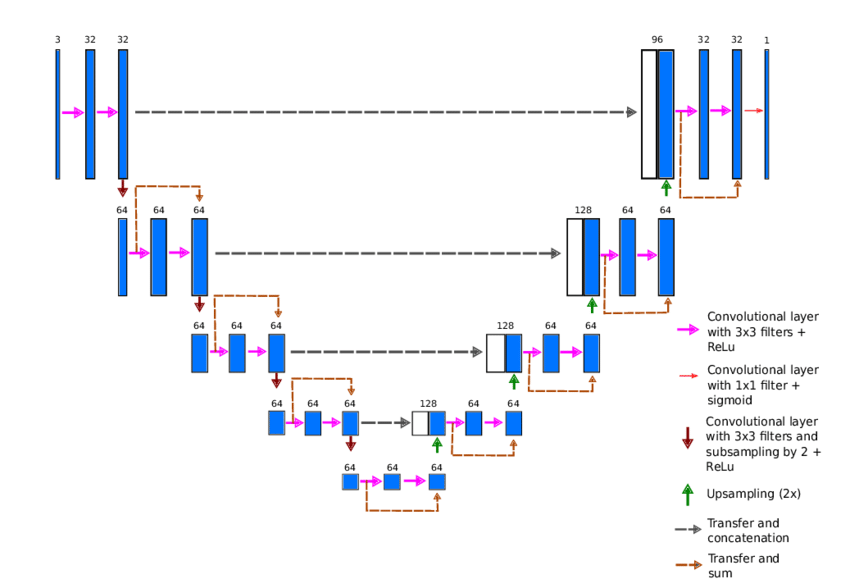

**Building a "U-Net" Model**

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model


#---------------------------------------------------------------------------------------------------------------------------------------------------------#

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Activation("relu")(x)
    return x

#---------------------------------------------------------------------------------------------------------------------------------------------------------#

'''Encoder or Contracting Block'''
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#---------------------------------------------------------------------------------------------------------------------------------------------------------#

'''Decoder or Expansive Block'''

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#---------------------------------------------------------------------------------------------------------------------------------------------------------#

'''Connecting the enocder to decoder using bottleneck and skip connections'''

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model
#---------------------------------------------------------------------------------------------------------------------------------------------------------#
'''Loading our Model'''
input_shape = (256, 256, 3) #input shape of images is (256,256,3)
model = build_unet(input_shape)
model.summary()

In [ ]:
smooth=1.
#-----------------------------------------------------------------------------------------------------------------------------------------------------------#
'''Function for returning dice coefficient'''
def DICE_COEFF(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)
#-----------------------------------------------------------------------------------------------------------------------------------------------------------#

'''Dice Coefficient Loss'''
def dice_coef_loss(y_true, y_pred):
    return 1 - DICE_COEFF(y_true, y_pred)

#----------------------------------------------------------------------------------------------------------------------------------------------------------#
'''Function for combining binary cross entropy with dice coeffcients for loss function'''
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

#----------------------------------------------------------------------------------------------------------------------------------------------------------#

'''Function for Jacards coefficient'''
def IOU_JACARD(y_true, y_pred):
    y_true=K.flatten(y_true)
    y_pred=K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    sum_jac = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_jac - intersection + smooth)
    return jac


Parameters for training Model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 16
learning_rate = 1e-4


Setting up train generator and validation generator

In [ ]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

train_generator = image_augmentor(MRI_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(256,256))
    
validation_generator = image_augmentor(MRI_val, BATCH_SIZE,
                                dict(),
                                target_size=(256,256))

In [ ]:
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

callbacks = [ModelCheckpoint('MRI_Segment.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=12)]

In [ ]:
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[IOU_JACARD, DICE_COEFF])

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(MRI_train) // 16, 
                    epochs=100, 
                    callbacks=callbacks,
                    validation_data = validation_generator,
                    validation_steps=len(MRI_val) // 16)

In [ ]:
model.save('Segmentation_MRI_BRAIN_01_Model.h5')

In [ ]:


test_gen = image_augmentor(MRI_test, BATCH_SIZE,
                                dict(),
                                target_size=(256,256))
results = model.evaluate(test_gen, steps=len(MRI_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])



In [ ]:
for i in range(50):
    index=np.random.randint(1,len(MRI_test.index))
    img = cv2.imread(MRI_test['images'].iloc[index])
    img = cv2.resize(img ,(256,256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(MRI_test['masks'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()



In [ ]:
MRI_test